In [13]:
# Import all libraries needed to find this file
import os, sys, requests, csv
import pandas as pd
from bs4 import BeautifulSoup
from shapely.geometry import Point
import geopandas as gpd

In [14]:
# Link for the website that needs to be scraped
link = 'https://www.opendataphilly.org/dataset/crime-incidents'

# Function that gets the beautiful soup object of the given website
def scrape_website_links(website_link):
    page_response = requests.get(website_link)
    page_soup = BeautifulSoup(page_response.text, 'html.parser')
    return page_soup

# Saves the information for the scraped website
page_soup = scrape_website_links(link)

In [15]:
# Function that gets all the links for the csvs on the webpage
def years_links(page_soup, website_link):
    years_links_list = []
    for links in page_soup.find_all('li', class_='resource-item'): 
        for link in links.find_all('a', class_='heading'):
            title = link.get('title')
            page_link = link.get('href')
            if title[-5:] == '(CSV)':
                years_links_list.append(website_link + page_link[24:])         
    return years_links_list

# Saves a list of links for each csv and prints the list
years_links_list = years_links(page_soup, link)
print(years_links_list)

['https://www.opendataphilly.org/dataset/crime-incidents/resource/bd5fd15e-4a8f-40be-bfed-fecfaa03a14b', 'https://www.opendataphilly.org/dataset/crime-incidents/resource/a2373b85-408b-4144-84e9-cb24843e5f2b', 'https://www.opendataphilly.org/dataset/crime-incidents/resource/22a0ee62-8afa-4061-922a-3f44871d739c', 'https://www.opendataphilly.org/dataset/crime-incidents/resource/f37eddcc-f97a-4b65-96b2-4b60a4110990', 'https://www.opendataphilly.org/dataset/crime-incidents/resource/64c305c7-28fa-4732-b40c-d2c2c6bfbf00', 'https://www.opendataphilly.org/dataset/crime-incidents/resource/09ddaad5-4621-4df4-97f6-096c5ca901f9', 'https://www.opendataphilly.org/dataset/crime-incidents/resource/de96ca38-b576-41a4-8bda-238b8b403a8a', 'https://www.opendataphilly.org/dataset/crime-incidents/resource/27a6d931-2691-44c2-a35a-97b94a71220f', 'https://www.opendataphilly.org/dataset/crime-incidents/resource/a05e0883-4b6a-4f20-bf8e-92e6ec4b939d', 'https://www.opendataphilly.org/dataset/crime-incidents/resourc

In [16]:
# Function that goes into each link in the list and grabs the download links to the data
# It also cleans up some links since they are broken
def csv_links(years_links_list):
    csv_link_list = []
    for link in years_links_list:
        page_soup = scrape_website_links(link)
        for info in page_soup.find_all('a', class_='btn btn-primary resource-url-analytics resource-type-None'):
            link_fix = info.get('href').replace(' ','%20')
            if link_fix[-3:] != '%27':
                link_fix = link_fix[:-1] + '%27'
            csv_link_list.append(link_fix)
    return csv_link_list

# Saves a list of links for each csv and prints the list
csv_link_list = csv_links(years_links_list)
print(csv_link_list)

['https://phl.carto.com/api/v2/sql?filename=incidents_part1_part2&format=csv&q=SELECT%20*%20,%20ST_Y(the_geom)%20AS%20lat,%20ST_X(the_geom)%20AS%20lng%20FROM%20incidents_part1_part2%20WHERE%20dispatch_date_time%20%3E=%20%272021-01-01%27%20AND%20dispatch_date_time%20%3C%20%272022-01-01%27', 'https://phl.carto.com/api/v2/sql?filename=incidents_part1_part2&format=csv&q=SELECT%20*%20,%20ST_Y(the_geom)%20AS%20lat,%20ST_X(the_geom)%20AS%20lng%20FROM%20incidents_part1_part2%20WHERE%20dispatch_date_time%20%3E=%20%272020-01-01%27%20AND%20dispatch_date_time%20%3C%20%272021-01-01%27', "https://phl.carto.com/api/v2/sql?filename=incidents_part1_part2&format=csv&skipfields=cartodb_id,the_geom,the_geom_webmercator&q=SELECT%20*%20,%20ST_Y(the_geom)%20AS%20lat,%20ST_X(the_geom)%20AS%20lng%20FROM%20incidents_part1_part2%20WHERE%20dispatch_date_time%20>=%20'2019-01-01'%20AND%20dispatch_date_time%20<%20'2020-01-01%27", "https://phl.carto.com/api/v2/sql?filename=incidents_part1_part2&format=csv&skipfields=

In [19]:
# Functions that downloads each csv and places them in local storage
# If the file already exists, then it skips and goes to the next one
# Displays which files were added
def download_csvs(csv_link_list):
    for counter, link in enumerate(csv_link_list):
        year = str(2021 - counter)
        csv_path = os.getcwd() + '/sample_data/crime_data/' + year + '.csv'
        if not os.path.exists(csv_path):         
            request = requests.get(link)
            request_content = request.content
            with open(csv_path, 'wb') as csv_file:
                csv_file.write(request_content)
            print('Added ' + year + ' crime data')

# Runs function
download_csvs(csv_link_list)    

In [20]:
# Function that creates a dataframe for each csv file
# Only keeps the important data in each dataframe
# Formats to the time to datatime format
# Combines all the year dataframe into one
def create_pandas_dataframe():
    full_list = pd.DataFrame()
    path = os.getcwd() + '/sample_data/crime_data/'
    for info in os.listdir(path):
        if info[-3:] == 'csv':
            columns_list = ['dispatch_date_time', 'text_general_code', 'lat', 'lng']
            dtypes_list = {'dispatch_date_time' : 'str',
                           'text_general_code' : 'str', 
                           'lat' : 'float64', 
                           'lng' : 'float64'}
            data = pd.read_csv((path + info), sep=',', usecols=columns_list, dtype=dtypes_list)
            full_list = full_list.append(data, ignore_index=True)
            
    full_list = full_list.rename(columns={'dispatch_date_time': 'dispatch_time',
                                          'text_general_code' : 'crime_type',
                                          'lat' : 'latitude',
                                          'lng' : 'longitude'})
    full_list['dispatch_time'] = pd.to_datetime(full_list['dispatch_time'])
    return full_list

# Saves the dataframe and prints it out
crime_df = create_pandas_dataframe()      
print(crime_df.head(10))

        dispatch_time                  crime_type   latitude  longitude
0 2017-10-18 00:10:00             Robbery Firearm  39.914430 -75.220592
1 2017-07-10 09:35:00    Burglary Non-Residential  40.049264 -75.066628
2 2017-10-31 09:59:00                      Thefts  40.049264 -75.066628
3 2017-11-06 21:22:00  Aggravated Assault Firearm  39.962334 -75.161446
4 2017-08-06 05:51:00          Robbery No Firearm  39.960712 -75.141441
5 2017-12-01 17:11:00                      Thefts  39.883881 -75.230706
6 2017-12-04 14:41:00                      Thefts  39.883881 -75.230706
7 2017-10-02 13:58:00                      Thefts  39.883881 -75.230706
8 2017-10-26 09:38:00                      Thefts  39.883881 -75.230706
9 2017-10-31 13:55:00                      Thefts  39.883881 -75.230706


In [21]:
# Function that finds the unique crime types
def crime_type_database(crime_df):
    return crime_df['crime_type'].unique()

# Saves a list of unique and prints the list
crimes_list = crime_type_database(crime_df)
print(crimes_list)

['Robbery Firearm' 'Burglary Non-Residential' 'Thefts'
 'Aggravated Assault Firearm' 'Robbery No Firearm' 'Theft from Vehicle'
 'Burglary Residential' 'Aggravated Assault No Firearm' 'Rape' 'Fraud'
 'All Other Offenses' 'Other Assaults' 'Narcotic / Drug Law Violations'
 'Vandalism/Criminal Mischief' 'Arson' 'DRIVING UNDER THE INFLUENCE'
 'Disorderly Conduct' 'Embezzlement'
 'Prostitution and Commercialized Vice' 'Public Drunkenness'
 'Forgery and Counterfeiting' 'Weapon Violations'
 'Other Sex Offenses (Not Commercialized)' 'Receiving Stolen Property'
 'Offenses Against Family and Children' 'Vagrancy/Loitering'
 'Liquor Law Violations' 'Gambling Violations' 'Homicide - Criminal'
 'Homicide - Criminal ' 'Motor Vehicle Theft' 'Homicide - Justifiable '
 'Recovered Stolen Motor Vehicle' 'Homicide - Gross Negligence']


In [22]:
# Function that cleans the dataframe to remove all non firearm realted crimes 
def return_firearm_data(crime_df):
    firearms_df = crime_df.loc[crime_df['crime_type'].str.contains('Firearm', case=False)]
    only_df = firearms_df.loc[~firearms_df['crime_type'].str.contains('No', case=False)]
    only_df = only_df.reset_index(drop=True)
    return only_df

# Saves the firearm dataframe and prints it out
firearms_used_df = return_firearm_data(crime_df)
print(firearms_used_df)

            dispatch_time                  crime_type   latitude  longitude
0     2017-10-18 00:10:00             Robbery Firearm  39.914430 -75.220592
1     2017-11-06 21:22:00  Aggravated Assault Firearm  39.962334 -75.161446
2     2017-08-10 01:42:00             Robbery Firearm  40.010933 -75.088733
3     2017-04-16 02:10:00  Aggravated Assault Firearm  39.963039 -75.135214
4     2017-08-14 01:16:00             Robbery Firearm  39.995967 -75.136045
...                   ...                         ...        ...        ...
91430 2019-12-10 20:57:00             Robbery Firearm  40.008050 -75.103833
91431 2019-12-02 14:39:00  Aggravated Assault Firearm  39.990494 -75.148942
91432 2019-11-15 00:59:00             Robbery Firearm  40.041907 -75.069552
91433 2019-10-12 11:40:00             Robbery Firearm  40.051901 -75.175189
91434 2019-11-12 21:49:00             Robbery Firearm  39.988710 -75.249742

[91435 rows x 4 columns]


In [23]:
# Shows the column info for the dataframe
firearms_used_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91435 entries, 0 to 91434
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dispatch_time  91435 non-null  datetime64[ns]
 1   crime_type     91435 non-null  object        
 2   latitude       91423 non-null  float64       
 3   longitude      91423 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 2.8+ MB


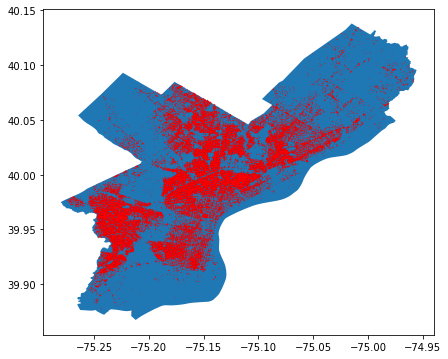

In [24]:
# Function that maps out Philadelphia and shows all the locations of the firearm realted crimes
def create_map(firearms_used_df):
    clean_data = firearms_used_df.loc[firearms_used_df['latitude'] > 39]
    geometry = [Point(xy) for xy in zip(clean_data['longitude'], clean_data['latitude'])]
    shootings_data = gpd.GeoDataFrame(clean_data, geometry=geometry)
    phila_map = gpd.read_file(os.getcwd() + '/sample_data/crime_data/maps/map.shp')
    shootings_data.plot(ax=phila_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=0.01)

# Runs the function
create_map(firearms_used_df)

In [12]:
# Function that saves dataframe to a csv file
def save_data(data):
    data.to_csv(os.getcwd() + '/produced_datasets/firearm_related_crimes.csv', index=False)

# Runs the function
save_data(firearms_used_df)